In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle

In [2]:
## Get RCP emissions, forcing:

s='85'

RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP_other_forc = RCP_forc['TOTAL_INCLVOLCANIC_RF'] - RCP_forc['CO2CH4N2O_RF']

RCP_E = pd.DataFrame(data = np.array([pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)[['OtherCO2','FossilCO2']].sum(axis=1).values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['CH4'].values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0).index)

Best_estimate_ems = pd.read_csv('Best_estimate_emissions_for_UnFaIR.csv',index_col=0)

In [3]:
SR15_DB = pd.read_csv('./Conc_fit_data/IAMC_T_RF_E_C.csv')
SR15_DB = SR15_DB.set_index(SR15_DB['Model'] + SR15_DB['Scenario'])
SR15_DB.columns = list(SR15_DB.columns)[:5] + list(range(2010,2101))

print(SR15_DB['Variable'].unique())

## Find all the model/scenario combinations which every current key variable has

variables = list(SR15_DB['Variable'].unique()[:3]) + list(SR15_DB['Variable'].unique()[7:-1])

common_index = set(SR15_DB.loc[SR15_DB['Variable']==variables[0]].index)

for var in variables[1:-1]:

    common_index = common_index.intersection(set(SR15_DB.loc[SR15_DB['Variable']==var].index))
    

['Emissions|CH4' 'Emissions|CO2' 'Emissions|N2O'
 'AR5 climate diagnostics|Temperature|Global Mean|FAIR|Expected value'
 'AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED'
 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value'
 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'
 'Concentration|CH4' 'Concentration|CO2' 'Concentration|N2O' 'Forcing'
 'Forcing|CH4' 'Forcing|CO2' 'Forcing|N2O' 'Temperature|Global Mean' nan]


/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


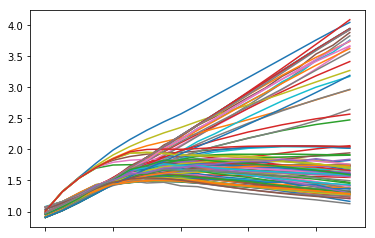

In [55]:
# Example request for data:

(SR15_DB.loc[SR15_DB['Variable']=='Temperature|Global Mean'].loc[common_index].iloc[:,5:].replace(to_replace=0.0,value=np.nan).T.interpolate()).plot(legend=None)

In [70]:
UnFaIR_scenarios = pd.DataFrame(columns=['Index','Variable'] + list(range(1765,2101)))

for i in np.arange(len(common_index)):

    scenario_choice = SR15_DB.loc[SR15_DB['Variable']=='Emissions|CO2'].loc[common_index].iloc[i].name

    CO2_scenario = SR15_DB.loc[SR15_DB['Variable']=='Emissions|CO2'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).interpolate().rename('CO2')
    CH4_scenario = SR15_DB.loc[SR15_DB['Variable']=='Emissions|CH4'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).interpolate().rename('CH4')
    N2O_scenario = SR15_DB.loc[SR15_DB['Variable']=='Emissions|N2O'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).interpolate().rename('N2O')

    scenario_df = pd.DataFrame([CO2_scenario*12/44/1000,CH4_scenario,N2O_scenario*28/44/1000]).T
    scenario_df = scenario_df.set_index(CO2_scenario.index.astype(int))

    #scenario_df = (RCP_E.loc[:2009] * scenario_df.loc[2010] / RCP_E.loc[2010]).append(scenario_df)
    scenario_df = (Best_estimate_ems.loc[:2009]).append(scenario_df+(Best_estimate_ems.loc[2010]-scenario_df.loc[2010]).values*np.linspace(1,0,2101-2010)[:,np.newaxis])

    total_forc_scenario = SR15_DB.loc[SR15_DB['Variable']=='Forcing'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate()
    CO2_forc_scenario = SR15_DB.loc[SR15_DB['Variable']=='Forcing|CO2'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate()
    CH4_forc_scenario = SR15_DB.loc[SR15_DB['Variable']=='Forcing|CH4'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate()
    N2O_forc_scenario = SR15_DB.loc[SR15_DB['Variable']=='Forcing|N2O'].loc[scenario_choice].iloc[5:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate()

    other_forc_scenario = (total_forc_scenario - CO2_forc_scenario - CH4_forc_scenario - N2O_forc_scenario)
    other_forc_scenario.index = total_forc_scenario.index.astype(int)

    #other_forc_scenario = (RCP_other_forc.loc[:2009]+np.linspace(0,other_forc_scenario.loc[2010]-RCP_other_forc.loc[2010],RCP_other_forc.loc[:2009].size)).append(other_forc_scenario).values
    other_forc_scenario = (RCP_other_forc.loc[:2009]).append(other_forc_scenario+(RCP_other_forc.loc[2010]-other_forc_scenario.loc[2010])*np.linspace(1,0,2101-2010)).values
    
    model_run = UnFaIR(scenario_df,other_forc_scenario)
    
    ii = 11*i
    
    UnFaIR_scenarios.loc[ii] = [scenario_choice,'Emissions|CO2'] + list(model_run['E']['CO2'])
    UnFaIR_scenarios.loc[ii+1] = [scenario_choice,'Emissions|CH4'] + list(model_run['E']['CH4'])
    UnFaIR_scenarios.loc[ii+2] = [scenario_choice,'Emissions|N2O'] + list(model_run['E']['N2O'])
    UnFaIR_scenarios.loc[ii+3] = [scenario_choice,'Concentration|CO2'] + list(model_run['C']['CO2'])
    UnFaIR_scenarios.loc[ii+4] = [scenario_choice,'Concentration|CH4'] + list(model_run['C']['CH4'])
    UnFaIR_scenarios.loc[ii+5] = [scenario_choice,'Concentration|N2O'] + list(model_run['C']['N2O'])
    UnFaIR_scenarios.loc[ii+6] = [scenario_choice,'Forcing|CO2'] + list(model_run['RF']['CO2'])
    UnFaIR_scenarios.loc[ii+7] = [scenario_choice,'Forcing|CH4'] + list(model_run['RF']['CH4'])
    UnFaIR_scenarios.loc[ii+8] = [scenario_choice,'Forcing|N2O'] + list(model_run['RF']['N2O'])
    UnFaIR_scenarios.loc[ii+9] = [scenario_choice,'Forcing'] + list(model_run['RF']['Total'])
    UnFaIR_scenarios.loc[ii+10] = [scenario_choice,'Temperature|Global Mean'] + list(model_run['T']['Total'])
    

In [76]:
print(common_index)

{'REMIND 1.5EMC_lowEI_30$', 'MESSAGE V.3GEA_Eff_base', 'AIM/CGE 2.0SFCM_SSP2_Bio_2Degree', 'AIM/CGE 2.0ADVANCE_2020_WB2C', 'MESSAGE V.3GEA_Eff_1p5C_Delay2020', 'AIM/CGE 2.1TERL_Baseline_NoTransportPolicy', 'IMAGE 3.0.1ADVANCE_NoPolicy', 'MESSAGE-GLOBIOM 1.0ADVANCE_NoPolicy', 'REMIND 1.5EMC_LimSW_30$', 'C-ROADS-5.005Ratchet-1.5-noCDR', 'REMIND 1.7CEMICS-1.5-CDR12', 'MESSAGE-GLOBIOM 1.0ADVANCE_2020_1.5C-2100', 'REMIND 1.5EMC_LimSW_100$', 'AIM/CGE 2.0SFCM_SSP2_combined_Baseline', 'AIM/CGE 2.0SFCM_SSP2_ST_solar_2Degree', 'REMIND-MAgPIE 1.7-3.0SMP_2C_Sust', 'REMIND-MAgPIE 1.7-3.0SMP_1p5C_regul', 'IMAGE 3.0.1IMA15-RenElec', 'IMAGE 3.0.1IMA15-Eff', 'MESSAGE V.3GEA_Mix_1p5C_AdvNCO2_PartialDelay2020', 'REMIND-MAgPIE 1.7-3.0SMP_1p5C_lifesty', 'WITCH-GLOBIOM 4.2ADVANCE_INDC', 'AIM/CGE 2.0SFCM_SSP2_ST_wind_2Degree', 'REMIND-MAgPIE 1.7-3.0PEP_2C_full_NDC', 'REMIND-MAgPIE 1.7-3.0PEP_1p5C_full_goodpractice', 'WITCH-GLOBIOM 4.2ADVANCE_2020_Med2C', 'REMIND-MAgPIE 1.7-3.0PEP_1p5C_full_NDC', 'REMIND 1.7C

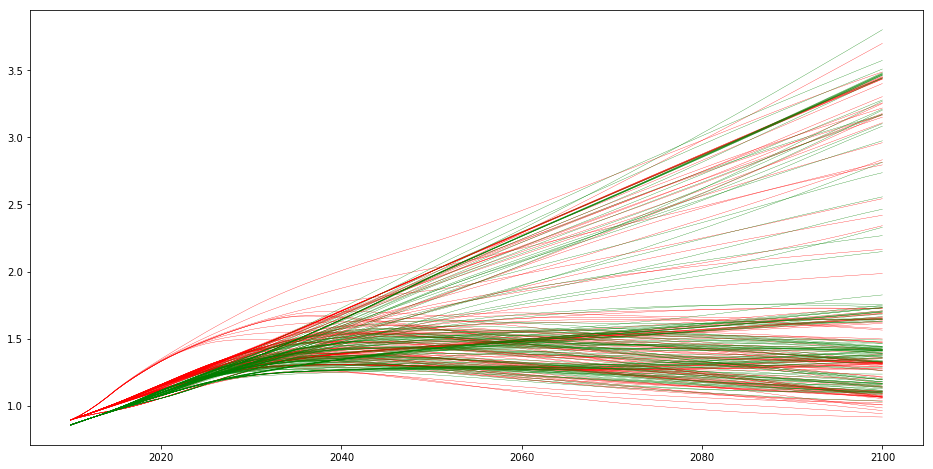

In [114]:
varchoice = 'Temperature|Global Mean'

all_variables = SR15_DB['Variable'].unique()

common_index_1 = set(SR15_DB.loc[SR15_DB['Variable']==variables[0]].index)

for var in all_variables[1:-1]:

    common_index_1 = common_index_1.intersection(set(SR15_DB.loc[SR15_DB['Variable']==var].index))

#modscen = 'C-ROADS-5.005Ratchet-1.5-limCDR-noOS'

fig,ax = plt.subplots(figsize=(16,8))

(UnFaIR_scenarios.loc[(UnFaIR_scenarios['Index'].isin(common_index_1))&(UnFaIR_scenarios['Variable']==varchoice)].T.iloc[247:,:]-1.0793+0.894).plot(ax=ax,legend=None,linewidth=0.3,color='r')
#SR15_DB.loc[SR15_DB['Variable']==varchoice].loc[common_index_1].T.iloc[5:,:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate().dropna(axis=1).plot(ax=ax,legend=None,linewidth=0.3,color='b')

SR15_DB.loc[SR15_DB['Variable']=='AR5 climate diagnostics|Temperature|Global Mean|FAIR|Expected value'].loc[common_index_1].T.iloc[5:,:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate().dropna(axis=1).plot(ax=ax,legend=None,linewidth=0.3,color='g')
#SR15_DB.loc[SR15_DB['Variable']=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value'].loc[common_index_1].T.iloc[5:,:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate().dropna(axis=1).plot(ax=ax,legend=None,linewidth=0.3,color='k')

#ax[0,0].set_title('UnFaIR')
#ax[0,1].set_title('IAMC Temps')
#ax[1,0].set_title('FAIR')
#ax[1,1].set_title('MAGICC6')

#else:
#    UnFaIR_scenarios.loc[(UnFaIR_scenarios['Index']==modscen)&(UnFaIR_scenarios['Variable']==varchoice)].T.iloc[247:,:].plot(legend=None,linewidth=1,color='r')
#    SR15_DB.loc[(SR15_DB.index==modscen)&(SR15_DB['Variable']==varchoice)].T.iloc[5:,:].apply(pd.to_numeric).replace(to_replace=0.0,value=np.nan).interpolate().dropna(axis=1).plot(legend=None,linewidth=1,color='b')